<a href="https://colab.research.google.com/github/szsavery/DSPS_SSavery/blob/main/HW10/PINN_Burgers_tofillinipynb_Savery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-12 01:09:05--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-12 01:09:06--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat.3’

burgers_shock.mat.3 100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2023-12-12 01:09:06 (9.13 MB/s) - ‘burgers_shock.mat.3’ s

(100,) (256,) (256, 100)


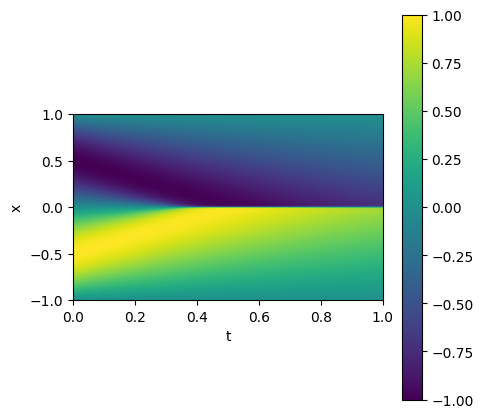

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


### Figure 1:

The actual solution to the shockfront that we want the neural network to recreate.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

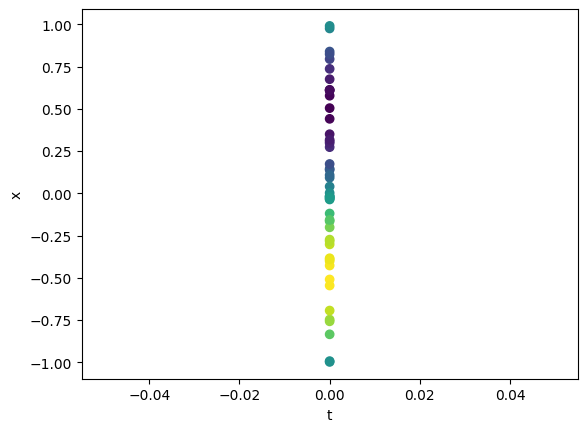

In [10]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### Figure 2:

The exact data points at t = 0 and x = 0. The color correlates to the function u.

# get data at boundaries of x at random t's



In [11]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754, -1.        ],
       [ 0.12354946, -1.        ],
       [ 0.7718717 ,  1.        ],
       [ 0.6850728 ,  1.        ],
       [ 0.6442598 ,  1.        ],
       [ 0.07745004,  1.        ],
       [ 0.75058556, -1.        ],
       [ 0.6250843 , -1.        ],
       [ 0.00772953, -1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694, -1.        ],
       [ 0.43658102, -1.        ],
       [ 0.9566101 , -1.        ],
       [ 0.7588576 , -1.        ],
       [ 0.8964343 , -1.        ],
       [ 0.44467843,  1.        ],
       [ 0.3243779 ,  1.        ],
       [ 0.3443855 , -1.        ],
       [ 0.91262174,  1.        ],
       [ 0.77731085,  1.        ],
       [ 0.899588  , -1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525, -1.        ],
       [ 0.5939442 ,  1.        ],
       [ 0.71862614,  1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [12]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

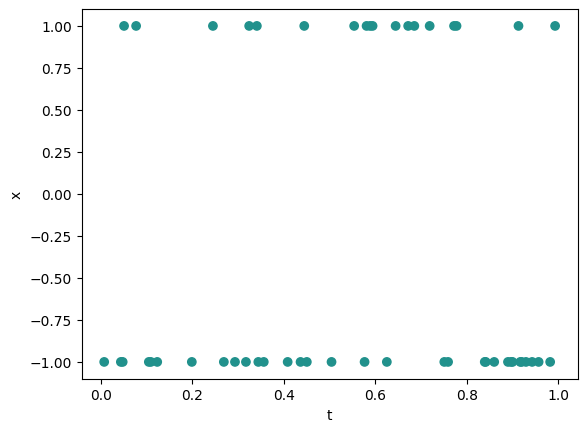

In [13]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### Figure 3:
Boundary conditions for the shockfront. As expected, they're all zero.

# get points inside the space at random where the function will be predicted

In [14]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

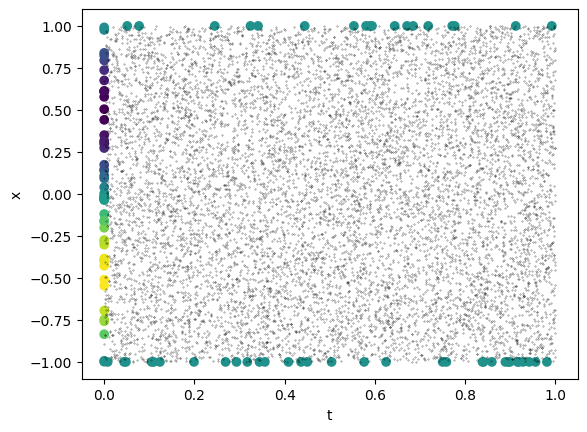

In [15]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### Figure 4:

Plotting 10000 random points between -1 < x < 1 as time moves forward.

In [16]:
#put boundary conditions together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [17]:
#Used the shared video to help fill this in
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.Input(2))

#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20,activation = "tanh"))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1))


In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

def custom_loss(u_pred, u_data):
  return tf.reduce_mean(tf.square(u_data-u_pred))

In [19]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [20]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 7s 10ms/step - loss: 0.2027
Epoch 2/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1889
Epoch 3/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1840
Epoch 4/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1783
Epoch 5/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1745
Epoch 6/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1751
Epoch 7/1000
4/4 [==============================] - 0s 7ms/step - loss: 0.1719
Epoch 8/1000
4/4 [==============================] - 0s 10ms/step - loss: 0.1696
Epoch 9/1000
4/4 [==============================] - 0s 11ms/step - loss: 0.1659
Epoch 10/1000
4/4 [==============================] - 0s 9ms/step - loss: 0.1534
Epoch 11/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1509
Epoch 12/1000
4/4 [==============================] - 0s 8ms/step - loss: 0.1437
Epoch 13/1000
4/4 [===========================

Text(0, 0.5, 'loss')

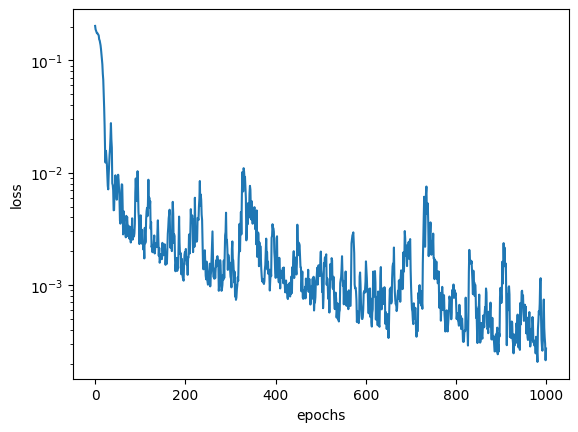

In [21]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

### Figure 5:
Plotting the loss function for as the epochs of the model increase. Need to run it for longer, as there are still some large jumps in the loss occuring. Though after 400 epochs, the majority of epochs have loss functions below $10^{-2}$.

## see the result

In [22]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 3ms/step


array([[-0.14570056],
       [-0.41321442],
       [ 0.17233679],
       ...,
       [-0.00805302],
       [ 0.4810581 ],
       [-0.6375484 ]], dtype=float32)

313/313 [==============================] - 1s 3ms/step


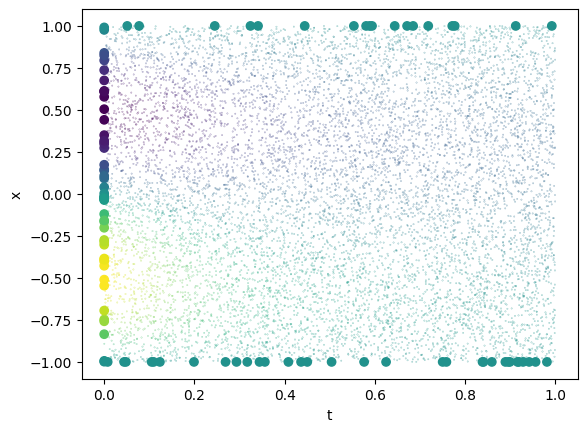

In [23]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### Figure 6:
Plotting the model's prediction at the 10000 random points that were found before. Can see that after about t = 0.05, the model defaults to predicting values of 0 for the different points. The model is putting too much weight on the x boundary conditions.

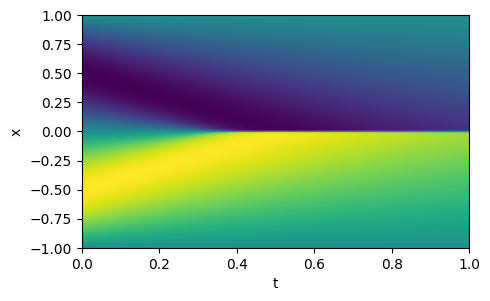

In [24]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


### Figure 7:

Again plotting the actual shockfront that we are trying to recreate.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


-38.48274061094519

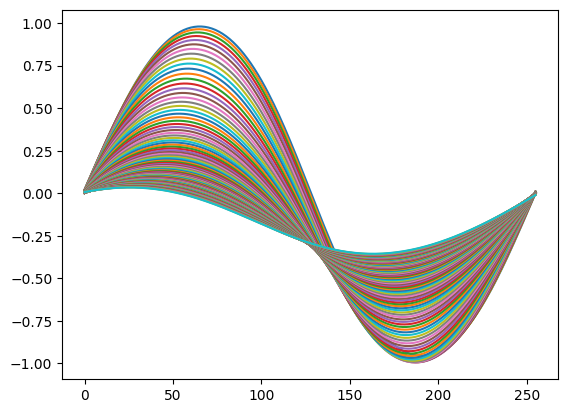

In [25]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

8/8 [==============================] - 0s 2ms/step


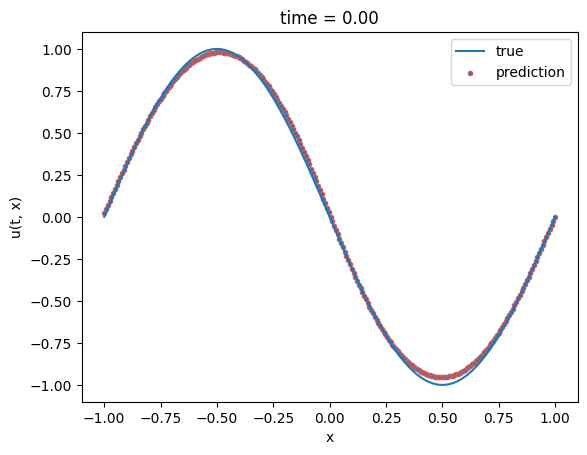

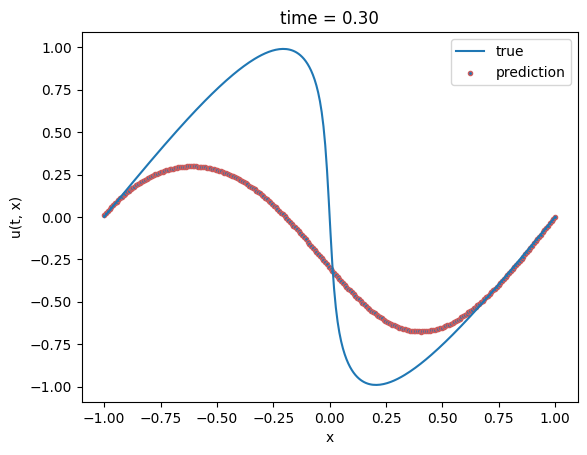

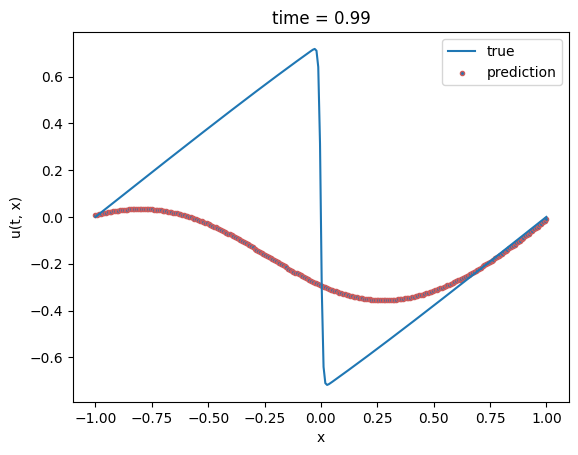

In [26]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


### Figure 8:
Plotting the model's prediction of u(t,x) at 3 different times. Confirms that the model moves to predicting u = 0 for all points very quickly.

# create the model with complete loss

In [27]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [28]:
#Code from shared video
def custom_loss2(model, X_r, X, y):
  u_pred = model(X)
  loss = custom_loss(u_pred, y)
  u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
  residuals = fun_res(u_pred, u_t, u_x, u_xx)
  loss += tf.reduce_mean(tf.square(residuals))
  return loss


In [29]:
#Code from shared video
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent = True) as tape:
      tape.watch(model.trainable_variables)
      loss = custom_loss2(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

## train the model

In [30]:
import copy

In [31]:
#Same model as before
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))
#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation = "tanh"))
#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))


In [32]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim2.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim2 = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss2, optimizer=optim2) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 2.93234527e-01
It 00050: loss = 8.64659250e-02
It 00100: loss = 7.04203844e-02
It 00150: loss = 5.18929809e-02
It 00200: loss = 4.51074913e-02
It 00250: loss = 4.48353775e-02
It 00300: loss = 8.61722603e-02
It 00350: loss = 2.31704880e-02
It 00400: loss = 1.96913015e-02
It 00450: loss = 1.95395947e-02
It 00500: loss = 8.61710086e-02
It 00550: loss = 2.65614502e-02
It 00600: loss = 8.13247263e-02
It 00650: loss = 8.43096152e-03
It 00700: loss = 6.75653061e-03
It 00750: loss = 1.03123253e-02
It 00800: loss = 3.37376632e-03
It 00850: loss = 4.29029390e-03
It 00900: loss = 1.61684882e-02
It 00950: loss = 2.15546554e-03
It 01000: loss = 8.35464150e-03
It 01050: loss = 2.16613198e-03
It 01100: loss = 1.30633125e-03
It 01150: loss = 5.21824509e-02
It 01200: loss = 2.62268493e-03
It 01250: loss = 1.13161048e-03
It 01300: loss = 8.84394918e-04
It 01350: loss = 1.65079138e-03
It 01400: loss = 7.85644050e-04
It 01450: loss = 3.04861390e-03
It 01500: loss = 1.49134733e-03
It 01550

313/313 [==============================] - 1s 2ms/step


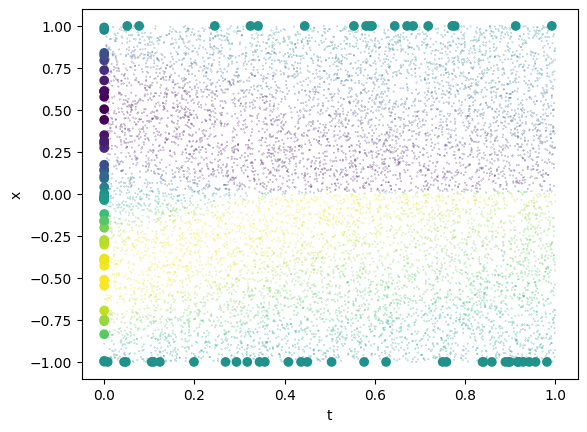

In [33]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### Figure 9:
Plotting the improved model's predictions for the 10000 random points. Looks much better, predicting purple and yellow points all the way out to t = 1 as wanted.

313/313 [==============================] - 1s 2ms/step


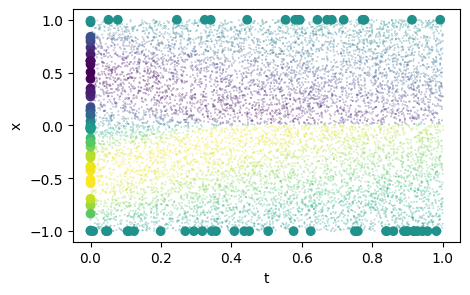

In [34]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

### Figure 10:
Replotting the improved model's predictions with the known boundary points.

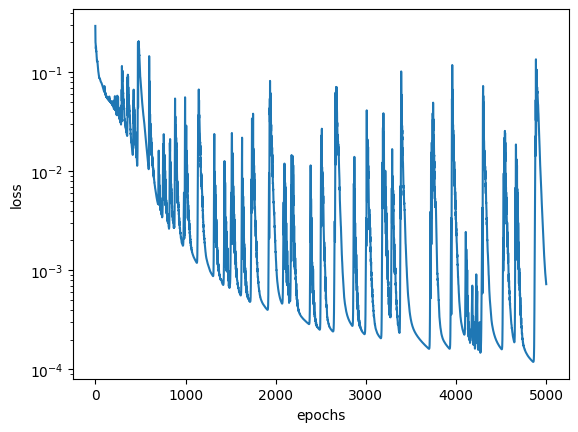

In [35]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

### Figure 11:
Shows that the overall loss function is continuing to decrease, even after 5000 epochs. Still have some large spikes in the loss function, where it increases towards $10^{-1}$. The model can still learn from running for more epochs.

8/8 [==============================] - 0s 2ms/step


2.1596687968818684

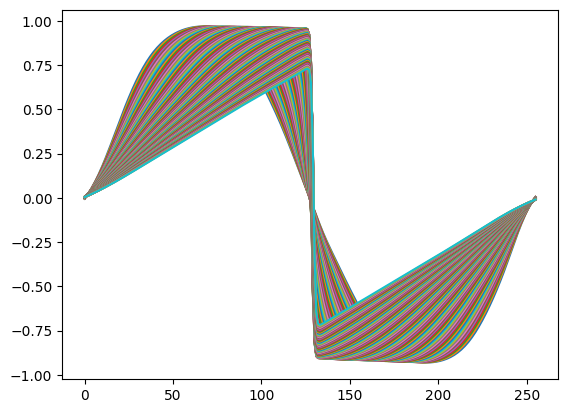

In [36]:
L1accuracy(t, x, pinn)

# adjust the learning rate and trin some more
the loss was awfully noisy

In [37]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [38]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 7.09224725e-04
It 00050: loss = 6.94921939e-04
It 00100: loss = 6.82231272e-04
It 00150: loss = 6.69926754e-04
It 00200: loss = 6.57857629e-04
It 00250: loss = 6.45981869e-04
It 00300: loss = 6.34275028e-04
It 00350: loss = 6.22725696e-04
It 00400: loss = 6.11322699e-04
It 00450: loss = 6.00063126e-04
It 00500: loss = 5.88946394e-04
It 00550: loss = 5.77966683e-04
It 00600: loss = 5.67124342e-04
It 00650: loss = 5.56424842e-04
It 00700: loss = 5.45865623e-04
It 00750: loss = 5.35441912e-04
It 00800: loss = 5.25157375e-04
It 00850: loss = 5.15004504e-04
It 00900: loss = 5.04991156e-04
It 00950: loss = 4.95114888e-04
It 01000: loss = 4.85364581e-04
It 01050: loss = 4.75735113e-04
It 01100: loss = 4.66213736e-04
It 01150: loss = 4.56785725e-04
It 01200: loss = 4.47431463e-04
It 01250: loss = 4.38110961e-04
It 01300: loss = 4.28772299e-04
It 01350: loss = 4.19353135e-04
It 01400: loss = 4.09757282e-04
It 01450: loss = 3.99907993e-04
It 01500: loss = 3.89800320e-04
It 01550

Text(0, 0.5, 'loss')

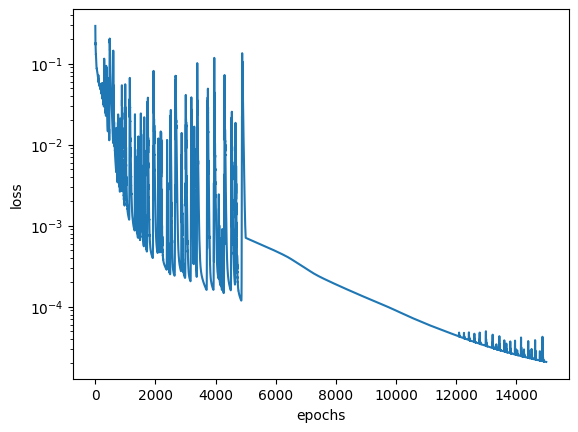

In [39]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

### Figure 12:
Plotting the model's loss function after 15000 epochs. The function is starting to flatten out, suggesting that the model is close to reaching its maximum of learning. Interestingly, the loss does still keep spike, but is staying below $10^{-4}$.

313/313 [==============================] - 1s 3ms/step


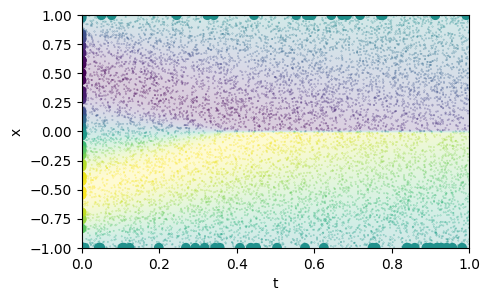

In [40]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

### Figure 13:
Plotting the model's prediction for the random points after running for 15000 epochs. Looks like a really good match for the wanted shockfront.

In [41]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 2.07733137e-05
It 00050: loss = 2.05811048e-05
It 00100: loss = 2.07719768e-05
It 00150: loss = 2.02254396e-05
It 00200: loss = 2.00731010e-05
It 00250: loss = 1.98594626e-05
It 00300: loss = 3.13303390e-05
It 00350: loss = 1.95223220e-05
It 00400: loss = 2.41919461e-05
It 00450: loss = 1.92074622e-05
It 00500: loss = 2.01213552e-05
It 00550: loss = 1.88723679e-05
It 00600: loss = 1.87087371e-05
It 00650: loss = 1.85523095e-05
It 00700: loss = 1.92617081e-05
It 00750: loss = 1.82974800e-05
It 00800: loss = 1.84687233e-05
It 00850: loss = 1.79710551e-05
It 00900: loss = 1.80084317e-05
It 00950: loss = 1.78477949e-05
It 01000: loss = 1.75580572e-05
It 01050: loss = 1.74204597e-05
It 01100: loss = 1.74486704e-05
It 01150: loss = 1.71593820e-05
It 01200: loss = 2.60681973e-05
It 01250: loss = 1.69427094e-05
It 01300: loss = 1.71924421e-05
It 01350: loss = 1.67992639e-05
It 01400: loss = 1.65365036e-05
It 01450: loss = 1.64151243e-05
It 01500: loss = 2.15250657e-05
It 01550

Text(0, 0.5, 'loss')

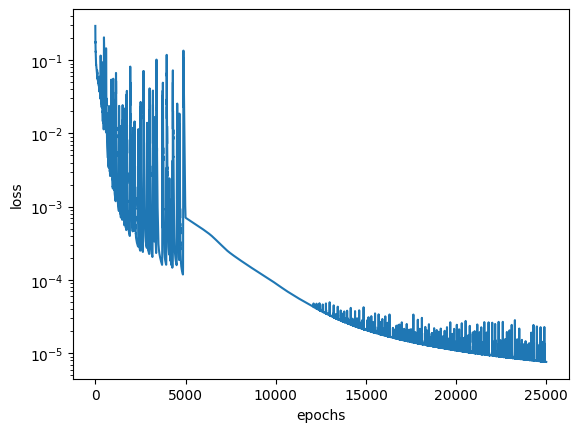

In [42]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

### Figure 14:
Running the model for another 10000 epochs. Shows that the loss function is still decreasing as the model continues to learn. The loss still periodically spikes, but is staying below $10^{-4}$.

## final result

8/8 [==============================] - 0s 3ms/step


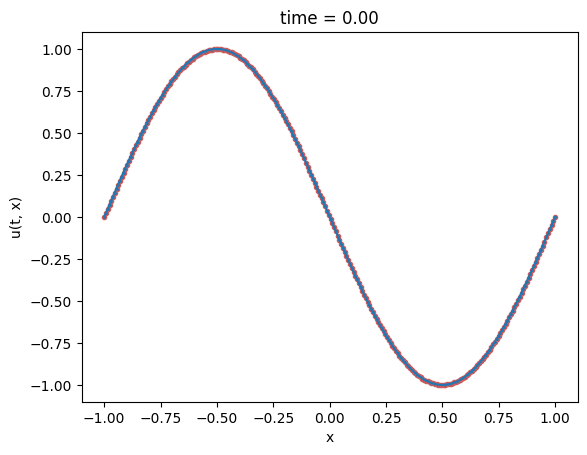

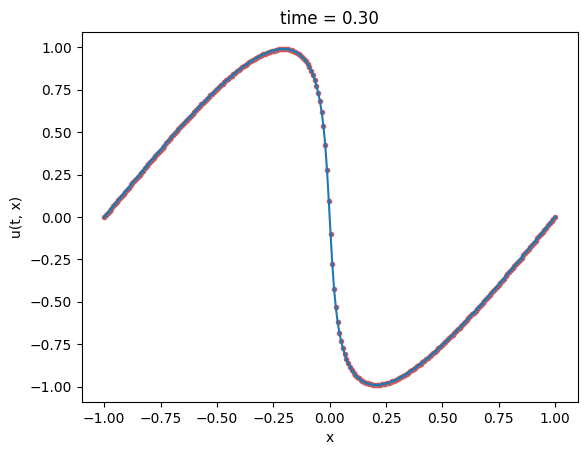

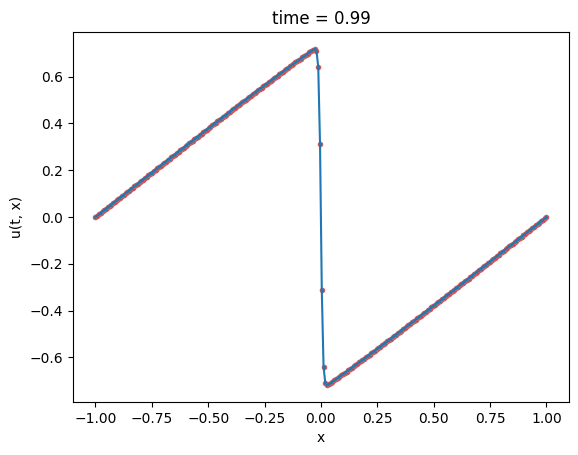

In [43]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

### Figure 15:
Plotting the improved model's guesses for u(t,x) at 3 different times. The predictions seem to fit the actual value for u(t,x) exactly. This is a vast improvement over the original model.

313/313 [==============================] - 1s 3ms/step


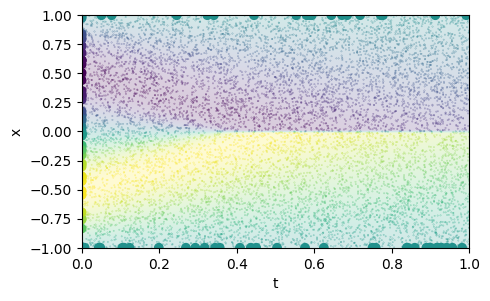

In [44]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

### Figure 16:
Plotting the model's predictions for the 10000 random points. Looks like a great fit for the wanted shockfront.

8/8 [==============================] - 0s 3ms/step


-0.12822700354287137

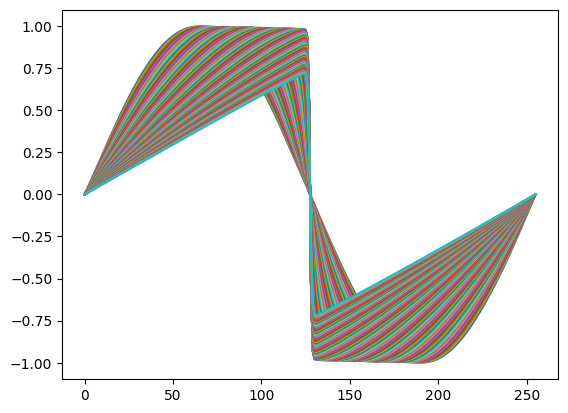

In [45]:
L1accuracy(t, x, pinn)